In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import dlc_practical_prologue as prologue

import matplotlib.pyplot as plt


In [2]:
train_input, train_target, train_classes, test_input, test_target, test_classes = [x.cuda() for x in prologue.generate_pair_sets(1000)]

# train_target=prologue.convert_to_one_hot_labels(train_input,train_target)

In [21]:
class ConvNet(nn.Module):
    '''
    Input size :            2x14x14
    nn.Conv2d(2, 32, k=3) : 32x12x12
    F.max_pool2d(k=2) :     32x6x6
    nn.Conv2d(32, 64, k=3): 64x4x4
    F.max_pool2d(k=2):      64x2x2
    '''
    def __init__(self, nb_digits):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.fc1 = nn.Linear(128, nb_digits)
        self.fc2 = nn.Linear(2 * nb_digits, 2)

    def forward(self, x):
        batch_size, nb_channels, image_rows, image_cols = x.size()
        
        # Reshape the tensor such that along batch dimention we have first image first batch element, second image first batch element,
        # first image second batch element, ...
        x = x.view(nb_channels * batch_size, 1, image_rows, image_cols)
        
        # The treatement for all single images is same
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        digits_pred = self.fc1(x.view(nb_channels * batch_size, -1))
        
        x = F.softmax(digits_pred, dim = 1)
        
        # group digit predictions for same batch element in same vector
        x = x.view(batch_size, -1)
        
        x = self.fc2(x)
        return x, digits_pred

In [25]:
def train_model(model, train_input, train_target, train_classes, nb_epochs = 50, mini_batch_size = 100, lr = 1e-3, beta = 0.5):
    criterion_digits = nn.CrossEntropyLoss()
    criterion_comparison = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)

    loss_train = torch.empty(nb_epochs, requires_grad = False).cuda()
    loss_test = torch.empty(nb_epochs, requires_grad = False).cuda()
    
    for e in range(nb_epochs):
        for b in range(0, train_input.size(0), mini_batch_size):
            batch_input   = train_input.narrow(0, b, mini_batch_size)
            batch_target  = train_target.narrow(0, b, mini_batch_size)
            batch_classes = train_classes.narrow(0, b, mini_batch_size).view(-1)
            
            output_comparison, digits_pred = model(batch_input)
            loss_digits     = criterion_digits(digits_pred, batch_classes)
            loss_comparison = criterion_comparison(output_comparison, batch_target)
            loss_tot = beta * loss_digits + (1 - beta) * loss_comparison
                        
            optimizer.zero_grad()
            
            loss_tot.backward()
            optimizer.step()
            
            loss_train[e] += loss_tot / mini_batch_size

            #model.eval()
            #batch_input   = test_input.narrow(0, b, mini_batch_size)
            #batch_target  = test_target.narrow(0, b, mini_batch_size)
            #batch_classes = test_classes.narrow(0, b, mini_batch_size).view(-1)
            
            #output_comparison, digits_pred = model(batch_input)
            #loss_digits     = criterion_digits(digits_pred, batch_classes)
            #loss_comparison = criterion_comparison(output_comparison, batch_target)
            #loss_tot = beta * loss_digits + (1 - beta) * loss_comparison
                        
            #loss_test[e] += loss_tot / mini_batch_size

            #model.train()

        
    plt.plot(loss_train.cpu().detach(), label = 'loss train')
    plt.plot(loss_test.cpu().detach(), label = 'loss test')

    plt.legend()
    plt.show()


In [26]:
def compute_nb_errors(model, data_input, data_target):
    nb_data_errors = 0
    mini_batch_size= 100
    
    for b in range(0, data_input.size(0), mini_batch_size):
        batch_input  = data_input.narrow(0, b, mini_batch_size)
        batch_target = data_target.narrow(0, b, mini_batch_size)
        
        output, _ = model(batch_input)
        predicted_classes = torch.argmax(output, 1)
                
        nb_data_errors += (predicted_classes != batch_target).sum()

    return nb_data_errors

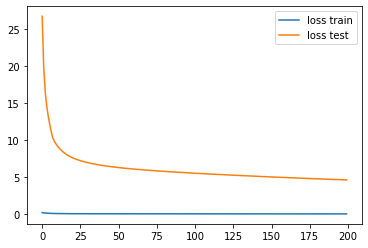

train_error 15.60% test_error 24.70%


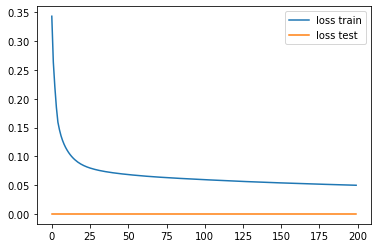

train_error 15.90% test_error 22.40%


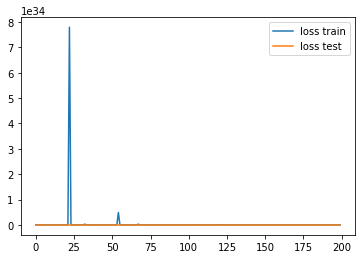

train_error 16.80% test_error 24.30%


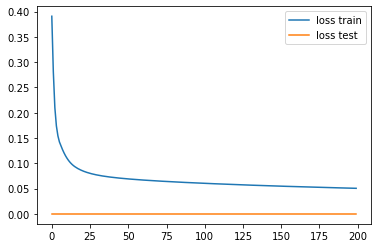

train_error 16.60% test_error 23.40%


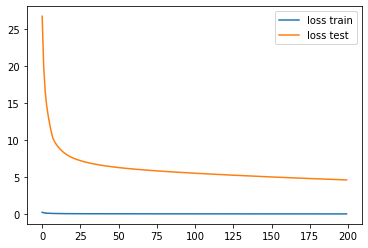

train_error 13.90% test_error 20.70%


In [27]:

train_E=[]
test_E=[]

for k in range(5):
    model=ConvNet(10).cuda()
    train_model(model, train_input, train_target, train_classes, beta = 0.1, lr = 1e-4, nb_epochs = 200, mini_batch_size = 100)
    train_E.append(compute_nb_errors(model, train_input, train_target) / train_input.size(0) * 100)
    test_E.append(compute_nb_errors(model, test_input, test_target) / test_input.size(0) * 100)
    
    print('train_error {:.02f}% test_error {:.02f}%'.format(train_E[-1],test_E[-1]))